In [ ]:
#libraries need to be installed 

In [1]:
import tensorflow as tf
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os, time 
from skimage import color
from skimage import io
import cv2 
import glob 
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.backend.tensorflow_backend import set_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# lets check gpu available 
tf.__version__
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from functions import image_data

In [4]:
# configuring the usage of gpu
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.99
config.gpu_options.visible_device_list = "0" 
set_session(tf.compat.v1.Session(config=config))   

In [5]:
X_seg_train = image_data('keras_png_slices_train')

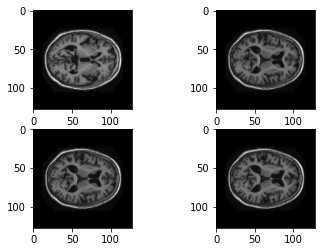

In [6]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(X_seg_train[1],cmap="gray")
axs[0, 1].imshow(X_seg_train[2],cmap="gray")
axs[1, 0].imshow(X_seg_train[3],cmap="gray")
axs[1, 1].imshow(X_seg_train[4],cmap="gray")

In [11]:
# reshape data to [8000, 128, 128, 1]
train_images = (X_seg_train - 127.5) / 127.5 # Normalize the images to [-1, 1]

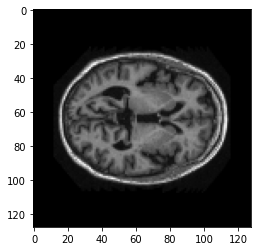

In [16]:
plt.imshow(train_images[1],cmap='gray')

In [17]:
BUFFER_SIZE = 8000
BATCH_SIZE = 128

In [18]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
from func

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')